In [20]:
# import libraries


import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

## Import Data

In [21]:
X = pd.read_csv('./data/X_regression.csv')

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8610 entries, 0 to 8609
Data columns (total 21 columns):
Month           8610 non-null int64
Species         8610 non-null object
Street          8610 non-null object
spray_dist      1334 non-null float64
spray_status    8610 non-null int64
Year            8610 non-null int64
Sunset          8610 non-null float64
DaylightHrs     8610 non-null float64
Tmax            8610 non-null float64
Tmin            8610 non-null float64
Tavg            8610 non-null float64
Depart          8610 non-null float64
DewPoint        8610 non-null float64
WetBulb         8610 non-null float64
Cool            8610 non-null float64
PrecipTotal     8610 non-null float64
StnPressure     8610 non-null float64
SeaLevel        8610 non-null float64
ResultSpeed     8610 non-null float64
ResultDir       8610 non-null float64
AvgSpeed        8610 non-null float64
dtypes: float64(16), int64(3), object(2)
memory usage: 1.4+ MB


In [23]:
X.spray_status.value_counts()

0    8343
1     267
Name: spray_status, dtype: int64

In [24]:
X.spray_dist.describe()

count    1334.000000
mean       14.334910
std        18.290622
min         0.000000
25%         3.640000
50%         7.440000
75%        18.452500
max        93.130000
Name: spray_dist, dtype: float64

I will just impute NaN values of spray_dist with an arbituary number of 150 (that's greater than the max)

In [25]:
X.spray_dist.fillna(150, inplace=True)

In [26]:
y = pd.read_csv('./data/y_regression.csv')

In [27]:
X_dummies = pd.get_dummies(X,drop_first=True,columns=['Species','Street'])

In [28]:
X_dummies.shape[1]

152

Obese dataset. We definitely need RFE or regularization later.

### Train Test Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies,y,test_size = 0.3, random_state = 666)

### OLS Linear Regression

In [30]:
# Using RobustScaler as the data could still contain some outliers
lr = make_pipeline(StandardScaler(), LinearRegression())

In [31]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.13485381552283904, -0.08187752988098129)

Even the training score is horrible...

#### RMSE 

In [32]:
np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))

41.815627085868705

### 2. Ridge (L2 Penalty)

In [33]:
# Using pipeline and gridsearch to optimize the hyper parameters
ridge_pipe= make_pipeline(StandardScaler(), Ridge())

In [34]:
ridge_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001))],
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'ridge': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__normalize': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.001}

In [35]:
ridge_params = {
    'ridge__alpha': np.logspace(0, 5, 200),
    'ridge__random_state': [42]
}

In [36]:
gs_ridge = GridSearchCV(estimator = ridge_pipe, 
                        param_grid = ridge_params,
                        verbose = 1,
                        n_jobs = -1,
                        cv = 5)

gs_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   22.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'ridge__alpha': array([1.00000e+00, 1.05956e+00, ..., 9.43788e+04, 1.00000e+05]), 'ridge__random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [25]:
gs_ridge.score(X_train, y_train), gs_ridge.score(X_test, y_test)

(0.9386710044395351, 0.9226982317777791)

#### RMSE

In [37]:
np.sqrt(mean_squared_error(y_test, gs_ridge.predict(X_test)))

38.69639107807072

With regularization and hyperparameters tuning, we are able to bring down the R2 score and RMSE!

In [42]:
gs_ridge.best_estimator_.named_steps['ridge'].coef_[0]

array([ 1.23018732e-01, -9.88179201e-01,  6.37529356e-01, -2.64998867e+00,
        1.22210738e+00,  1.01568118e+00,  4.47684597e-01,  6.13600993e-01,
        1.80374931e-01, -1.50549847e+00,  1.28914145e+00,  1.36460380e+00,
        4.53834657e-01,  8.10984682e-01,  1.75608132e-02, -6.74130035e-02,
       -5.69818714e-01,  1.29079890e-01, -1.19295636e+00,  2.58740801e+00,
        6.57055926e-01, -2.14954702e+00, -1.98386725e+00, -1.23834086e-01,
       -1.62059613e+00,  9.49902450e-01, -4.45938530e-01,  3.55104123e-01,
        2.27722070e-01,  4.78840706e-01, -4.44142451e-01, -7.65949957e-01,
        2.01559251e-01, -7.24442523e-01, -4.18164123e-01, -4.11913167e-01,
       -6.20926063e-01, -5.16197688e-01, -5.34527230e-01, -6.43933735e-01,
       -7.37357665e-01, -5.66400062e-01,  2.30097331e-01, -6.86650663e-01,
        1.11847956e-01, -6.03169252e-01, -5.68752700e-01, -2.81082169e-01,
       -2.73910341e-01, -4.04309167e-01, -6.52755828e-01, -6.05539041e-01,
       -5.99406265e-02, -

In [41]:
X_train.columns

Index(['Month', 'spray_dist', 'spray_status', 'Year', 'Sunset', 'DaylightHrs',
       'Tmax', 'Tmin', 'Tavg', 'Depart',
       ...
       'Street_ W MONTANA ST', 'Street_ W MONTROSE DR', 'Street_ W OHARE',
       'Street_ W OHARE AIRPORT', 'Street_ W PERSHING RD',
       'Street_ W ROOSEVELT', 'Street_ W ROSCOE ST', 'Street_ W STRONG ST',
       'Street_ W SUNNYSIDE AVE', 'Street_ W WEBSTER AVE'],
      dtype='object', length=152)

In [43]:
# Plot important coefficients
coefs = pd.Series(gs_ridge.best_estimator_.named_steps['ridge'].coef_[0], index = X_train.columns)

Ridge picked 152 features and eliminated the other 0 features


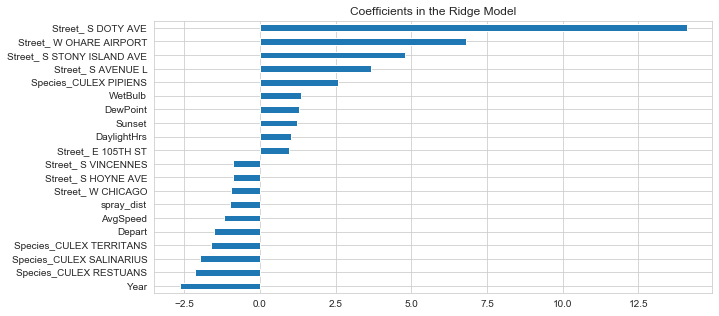

In [44]:
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh", figsize = (10,5))
plt.title("Coefficients in the Ridge Model")
plt.show()